In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import json


# VEST RI 2020

Note: This notebook performs only election data validation

In [2]:
STATE_NAME = 'ri'
STATE_YEAR = '2020'

#### Functions used

1. allocating votes

In [3]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

2. precinct level validation

In [4]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

3. state level validation

In [5]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

4. county level validation

In [6]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

## VEST's Documentation File

### Sources

Election results from Rhode Island Board of Elections (https://www.ri.gov/election/results/2020/general_election/data/)

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. (not applicable)

### Processing

Election data processing:
   - Limited ballots were reported by township. 
   - Federal ballots were reported by congressional district. These were distributed by candidate to precincts based on their share of the precinct-level vote for the given reporting unit.


Shapefile processing (non applicable):
- Several precincts in Providence were aligned with the city ward shapefile. 

### Candidates

#### President - PRE

- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20PREOFUE - Roque "Rocky" De La Fuente (Alliance Party)
- G20PREOLAR - Gloria La Rive (Socialism and Liberation Party)
- G20PREOCAR - Brian Carroll (American Solidarity Party)
- G20PREOWRI - Write-in Votes


#### U.S. Senate - USS

- G20USSDREE - John F. Reed (Democratic Party)
- G20USSRWAT - Allen R. Waters (Republican Party)
- G20USSOWRI - Write-in Votes

In [7]:
races = [
    #President
    'G20PREDBID',
    'G20PRERTRU',
    'G20PRELJOR',
    'G20PREOFUE',
    'G20PREOLAR',
    'G20PREOCAR',
    'G20PREOWRI',
    
    #U.S. Senate
    'G20USSDREE',
    'G20USSRWAT',
    'G20USSOWRI'
]

## Load in VEST file

In [8]:
state_name_year = STATE_NAME + '_' + STATE_YEAR
path_to_vest_file = 'raw-from-source/VEST/' + state_name_year + '/' + state_name_year + '.shp'
vest = gp.read_file(path_to_vest_file)

In [9]:
vest.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

<AxesSubplot:>

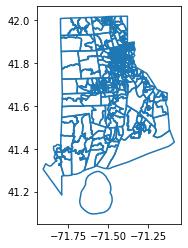

In [10]:
vest.boundary.plot()

In [11]:
vest.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREOFUE', 'G20PREOLAR', 'G20PREOCAR',
       'G20PREOWRI', 'G20USSDREE', 'G20USSRWAT', 'G20USSOWRI', 'geometry'],
      dtype='object')

In [12]:
vest.head(5)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOFUE,G20PREOLAR,G20PREOCAR,G20PREOWRI,G20USSDREE,G20USSRWAT,G20USSOWRI,geometry
0,44,009,443208,44009443208,South Kingstown 8,1562,839,27,1,3,9,17,1615,762,1,"POLYGON ((-71.60673 41.41403, -71.60623 41.415..."
1,44,007,440724,44007440724,Cranston 24,1322,290,8,5,0,3,14,1310,271,2,"POLYGON ((-71.40395 41.77325, -71.40316 41.774..."
2,44,005,ZZZZZZ,44005ZZZZZZ,Voting Districts Not Defined,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-71.50944 41.30773, -71.50660 41.312..."
3,44,005,441501,44005441501,JAMESTOWN 1,1547,651,22,0,5,1,10,1621,564,3,"POLYGON ((-71.38543 41.55423, -71.38534 41.554..."
4,44,005,441502,44005441502,JAMESTOWN 2,1261,562,22,1,5,2,9,1344,464,3,"POLYGON ((-71.42190 41.44900, -71.41727 41.455..."


In [13]:
vest.shape

(423, 16)

In [14]:
vest.STATEFP20.unique()

array(['44'], dtype=object)

make sure VTDST20 is a unique column

In [15]:
assert(len(vest['VTDST20']) == len(vest['VTDST20'].unique()))

Note: VTDST20 is a combination of two digit STATEFP20 (44) and the unique Precinct ID used by the source file

## Election Results

### Load, Clean, Pivot Election Results

In [16]:
source_filepath = 'raw-from-source/Election_Results/rigen2020l.asc'

Using non-standard method of importing due to the format of the file (.asc)

In [17]:
with open(source_filepath) as f:
    values = []
    for idx, line in enumerate(f):
        data = line.split('  ')
        data = list(filter(None, data))
        values.append(data)
    raw_df = pd.DataFrame(values)

isolate president race using race code 0301

In [18]:
pres_df = pd.DataFrame()
pres_df['race_num'] = raw_df[0].apply(lambda x: x[:4])
pres_df = pres_df[pres_df['race_num'] == '0301'] #isolates presidential race

pres_df['candidate'] = raw_df[0].apply(lambda x: x[4:7])
pres_df['candidate_name'] = raw_df[2]

pres_df['precinct'] = raw_df[0].apply(lambda x: x[7:11])
pres_df['precinct_name'] = raw_df[3]

pres_df['votes'] = raw_df[0].apply(lambda x: x[11:17]).astype(int)

display(pres_df)


,race_num,candidate,candidate_name,precinct,precinct_name,votes
0,0301,001,Donald J. Trump,0101,Barrington 0101,551
1,0301,001,Donald J. Trump,0102,Barrington 0102,623
2,0301,001,Donald J. Trump,0103,Barrington 0103,452
3,0301,001,Donald J. Trump,0104,Barrington 0104,646
4,0301,001,Donald J. Trump,0105,Barrington 0105,587
...,...,...,...,...,...,...
3523,0301,007,WRITE-IN,3914,Woonsocket Presidential,0
3524,0301,007,WRITE-IN,9001,Federal Precinct #1,0
3525,0301,007,WRITE-IN,9002,Federal Precinct #2,3
3526,0301,007,WRITE-IN,9011,Federal Precinct #1S,0


isolate senator race due to different column naming

In [19]:
senator_df = pd.DataFrame()
senator_df['race_num'] = raw_df[0].apply(lambda x: x[:4])
senator_df = senator_df[senator_df['race_num'] == '0302'] #isolates presidential race

senator_df['candidate'] = raw_df[0].apply(lambda x: x[4:7])
senator_df['candidate_name'] = raw_df[1]

senator_df['precinct'] = raw_df[0].apply(lambda x: x[7:11])
senator_df['precinct_name'] = raw_df[2]

senator_df['votes'] = raw_df[0].apply(lambda x: x[11:17]).astype(int)

display(senator_df)


,race_num,candidate,candidate_name,precinct,precinct_name,votes
3528,0302,001,Allen R. Waters,0101,Barrington 0101,485
3529,0302,001,Allen R. Waters,0102,Barrington 0102,585
3530,0302,001,Allen R. Waters,0103,Barrington 0103,477
3531,0302,001,Allen R. Waters,0104,Barrington 0104,598
3532,0302,001,Allen R. Waters,0105,Barrington 0105,588
...,...,...,...,...,...,...
4918,0302,003,WRITE-IN,3913,Woonsocket Limited,0
4919,0302,003,WRITE-IN,9001,Federal Precinct #1,0
4920,0302,003,WRITE-IN,9002,Federal Precinct #2,0
4921,0302,003,WRITE-IN,9011,Federal Precinct #1S,0


Clean the resulting dataframe due to the following two issues:
- Providence Limited is not split correctly into Providence and Limited to produce a correct county name - due to Providence Limited votes split into 2

In [20]:
pres_df['township'] = pres_df['precinct_name'].apply(lambda x: x.rsplit(' ', 1)[0])
pres_df['township'] = pres_df['township'].apply(lambda x: x.strip())
pres_df['township'] = pres_df['township'].replace({'Providence Limited': 'Providence'})

Create dictionaries to translate from id to township and from id to precinct name, to be used for vote allocation and validation

In [21]:
id_to_township = pres_df[['precinct', 'township']]
id_to_township_dict = dict(id_to_township.values)
id_to_name = pres_df[['precinct', 'precinct_name']]
id_to_name_dict = dict(id_to_name.values)

Combine both dataframes

In [22]:
del pres_df['township']
pre_pivot = pd.concat([senator_df, pres_df])

Create a new column that combines race number and candidate number to create unique columns in final dataframe

In [23]:
pre_pivot['race_cand'] = pre_pivot['race_num'] + pre_pivot['candidate']

Create a dictionary that translates from race_cand column to VEST race name

In [24]:
race_cand_to_code_dict = {
    #President
    '0301002': 'G20PREDBID',
    '0301001': 'G20PRERTRU',
    '0301006': 'G20PRELJOR',
    '0301003': 'G20PREOFUE',
    '0301005': 'G20PREOLAR',
    '0301004': 'G20PREOCAR',
    '0301007': 'G20PREOWRI',
    
    #U.S. Senate
    '0302002': 'G20USSDREE',
    '0302001': 'G20USSRWAT',
    '0302003': 'G20USSOWRI'
}

#### Perform the pivot

In [25]:
pivoted = pd.pivot_table(pre_pivot,values=["votes"],index=["precinct"],columns=["race_cand"],aggfunc=sum)
pivoted=pivoted.fillna(0)
pivoted.reset_index(drop=False,inplace=True)
pivoted.columns = pivoted.columns.droplevel(0)


Use source race code and cand name field to map to VEST race codes

In [26]:
pivoted.columns = pivoted.columns.map(race_cand_to_code_dict)
cols = pivoted.columns.to_list()
del cols[0]
cols = ['precinctid'] + cols
pivoted.columns = cols
display(pivoted)


,precinctid,G20PRERTRU,G20PREDBID,G20PREOFUE,G20PREOCAR,G20PREOLAR,G20PRELJOR,G20PREOWRI,G20USSRWAT,G20USSDREE,G20USSOWRI
0,0101,551.0,1247.0,0.0,4.0,1.0,17.0,11.0,485.0,1307.0,4.0
1,0102,623.0,1714.0,3.0,0.0,2.0,25.0,9.0,585.0,1742.0,0.0
2,0103,452.0,1379.0,4.0,4.0,1.0,22.0,16.0,477.0,1372.0,2.0
3,0104,646.0,1624.0,2.0,4.0,6.0,20.0,15.0,598.0,1665.0,3.0
4,0105,587.0,1685.0,4.0,2.0,2.0,29.0,25.0,588.0,1691.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
499,3914,135.0,124.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
500,9001,42.0,526.0,0.0,0.0,1.0,3.0,0.0,36.0,461.0,0.0
501,9002,26.0,474.0,0.0,0.0,3.0,2.0,3.0,30.0,429.0,0.0
502,9011,14.0,230.0,0.0,0.0,0.0,1.0,0.0,12.0,212.0,0.0


Use previously created dictionaries to create columns for township and precinct_name

In [27]:
pivoted['township'] = pivoted['precinctid'].map(id_to_township_dict)
pivoted['precinct_name'] = pivoted['precinctid'].map(id_to_name_dict)


Isolate federal level votes for later distribution

In [28]:
non_federal_df = pivoted[pivoted.township != 'Federal Precinct']
federal_df = pivoted[pivoted.township == 'Federal Precinct']

#### Perform statewide election data validation

In [29]:
statewide_totals_check(vest,pivoted,races)

***Statewide Totals Check***
G20PREDBID is equal 	VEST / RDH: 307486
G20PRERTRU is equal 	VEST / RDH: 199922
G20PRELJOR is equal 	VEST / RDH: 5053
G20PREOFUE is equal 	VEST / RDH: 923
G20PREOLAR is equal 	VEST / RDH: 847
G20PREOCAR is equal 	VEST / RDH: 767
G20PREOWRI is equal 	VEST / RDH: 2759
G20USSDREE is equal 	VEST / RDH: 328574
G20USSRWAT is equal 	VEST / RDH: 164855
G20USSOWRI is equal 	VEST / RDH: 833


### Distribute federal and township level votes

#### Distribute federal-level votes

In [30]:
federal_df

,precinctid,G20PRERTRU,G20PREDBID,G20PREOFUE,G20PREOCAR,G20PREOLAR,G20PRELJOR,G20PREOWRI,G20USSRWAT,G20USSDREE,G20USSOWRI,township,precinct_name
500,9001,42.0,526.0,0.0,0.0,1.0,3.0,0.0,36.0,461.0,0.0,Federal Precinct,Federal Precinct #1
501,9002,26.0,474.0,0.0,0.0,3.0,2.0,3.0,30.0,429.0,0.0,Federal Precinct,Federal Precinct #2
502,9011,14.0,230.0,0.0,0.0,0.0,1.0,0.0,12.0,212.0,0.0,Federal Precinct,Federal Precinct #1S
503,9012,3.0,46.0,0.0,0.0,0.0,0.0,0.0,3.0,45.0,0.0,Federal Precinct,Federal Precinct #2S


Isolate Congress Representative election data 

In [31]:
rep_df = raw_df[raw_df[0].str.contains('Representative in Congress District')]

Create a dataframe that contains precinct id and district number:
- chars in position 108-111 correspond with district number
- 0030 refers to district 1, while 0031 refers to district 2

In [32]:
district_df = pd.DataFrame()
district_df['precinct'] = rep_df[0].apply(lambda x: x[7:11])
district_df['district'] = rep_df[0].apply(lambda x: x[107:111])
district_df['district'] = district_df['district'].replace({'0030': '1'})
district_df['district'] = district_df['district'].replace({'0031': '2'})


Convert the df into a dictionary to be used for vote distribution

In [33]:
id_to_district_dict = dict(district_df.values)

Create a district column in both precinct-level and federal-level dfs

In [34]:
non_federal_df['district'] = non_federal_df['precinctid'].map(id_to_district_dict)
federal_df['district'] = federal_df['precinctid'].map(id_to_district_dict)

<ipython-input-34-d2311f3f8534>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_federal_df['district'] = non_federal_df['precinctid'].map(id_to_district_dict)
<ipython-input-34-d2311f3f8534>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  federal_df['district'] = federal_df['precinctid'].map(id_to_district_dict)


In [35]:
federal_df

,precinctid,G20PRERTRU,G20PREDBID,G20PREOFUE,G20PREOCAR,G20PREOLAR,G20PRELJOR,G20PREOWRI,G20USSRWAT,G20USSDREE,G20USSOWRI,township,precinct_name,district
500,9001,42.0,526.0,0.0,0.0,1.0,3.0,0.0,36.0,461.0,0.0,Federal Precinct,Federal Precinct #1,1
501,9002,26.0,474.0,0.0,0.0,3.0,2.0,3.0,30.0,429.0,0.0,Federal Precinct,Federal Precinct #2,2
502,9011,14.0,230.0,0.0,0.0,0.0,1.0,0.0,12.0,212.0,0.0,Federal Precinct,Federal Precinct #1S,1
503,9012,3.0,46.0,0.0,0.0,0.0,0.0,0.0,3.0,45.0,0.0,Federal Precinct,Federal Precinct #2S,2


Perform the distribution

In [36]:
pre_township_alloc = allocate_absentee(non_federal_df,federal_df,races,'district')

/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/izzy/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy 

#### Perform township level election data validation

Create a township column in vest df using names of precincts

In [37]:
vest['township'] = vest['NAME20'].apply(lambda x: x.rsplit(' ', 1)[0].title())

Filter out township not present in source (which has zero votes and is not an official township)

In [38]:
vest_filter_township = vest[vest['township'] != 'Voting Districts Not']
display(vest[vest['township'] == 'Voting Districts Not'])

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREOFUE,G20PREOLAR,G20PREOCAR,G20PREOWRI,G20USSDREE,G20USSRWAT,G20USSOWRI,geometry,township
2,44,005,ZZZZZZ,44005ZZZZZZ,Voting Districts Not Defined,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-71.50944 41.30773, -71.50660 41.312...",Voting Districts Not


Check vote totals

In [39]:
county_totals_check(vest_filter_township,pre_township_alloc,races,'township',full_print=False)

***Countywide Totals Check***

G20PREDBID contains differences in these counties:
	Barrington has a difference of 1.0 votes
		VEST: 7752 votes
		SOURCES: 7751.0 votes
	Bristol has a difference of -2.0 votes
		VEST: 6845 votes
		SOURCES: 6847.0 votes
	Burrillville has a difference of -2.0 votes
		VEST: 3445 votes
		SOURCES: 3447.0 votes
	Central Falls has a difference of 1.0 votes
		VEST: 3089 votes
		SOURCES: 3088.0 votes
	Charlestown has a difference of -2.0 votes
		VEST: 2917 votes
		SOURCES: 2919.0 votes
	Coventry has a difference of -4.0 votes
		VEST: 9153 votes
		SOURCES: 9157.0 votes
	Cranston has a difference of 2.0 votes
		VEST: 23119 votes
		SOURCES: 23117.0 votes
	East Greenwich has a difference of 4.0 votes
		VEST: 5239 votes
		SOURCES: 5235.0 votes
	East Providence has a difference of 1.0 votes
		VEST: 14810 votes
		SOURCES: 14809.0 votes
	Exeter has a difference of -1.0 votes
		VEST: 1980 votes
		SOURCES: 1981.0 votes
	Jamestown has a difference of -1.0 votes
		VEST: 2808 

#### Distribute township-level votes

Separate township-level and precinct-level votes into two dataframes

In [40]:
townshipwide = pre_township_alloc[pre_township_alloc['precinct_name'].str.contains('Presidential|Limited')]
non_townshipwide = pre_township_alloc.drop(townshipwide.index)

Perform the distribution

In [41]:
source = allocate_absentee(non_townshipwide,townshipwide,races,'township')

### Merge Source and VEST df

Create a joinid field

In [42]:
vest['joinid'] = vest['VTDST20']
source['joinid'] = vest.STATEFP20.unique()[0] + source['precinctid'].astype(str)

<ipython-input-42-2cd22a1bd623>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['joinid'] = vest.STATEFP20.unique()[0] + source['precinctid'].astype(str)


Perform the merge

In [43]:
join_attempt = pd.merge(vest,source,how="outer",on="joinid",indicator=True)
print(join_attempt["_merge"].value_counts())


merged = join_attempt[join_attempt["_merge"]=="both"]
right_only = join_attempt[join_attempt["_merge"]=="right_only"]
left_only = join_attempt[join_attempt["_merge"]=="left_only"]

left_only.to_csv('./left_only.csv')

both          421
left_only       2
right_only      0
Name: _merge, dtype: int64


Ensure non-merged precincts are zero-vote
- Since left_only didn't merge, we'll be checking if any race_x votes are non_zero

In [44]:
data_columns = races
empty_precincts = []
for index, row in left_only.iterrows():
    number_of_zero_races = 0
    for race in data_columns:
        if (row[race + '_x']==0):
            number_of_zero_races+= 1
    if(number_of_zero_races == len(data_columns)):
        empty_precincts.append(row["joinid"])
print(len(empty_precincts))
assert(len(empty_precincts) == len(left_only))

2


Perform precinct-level validation

In [45]:
precinct_votes_check(merged,races,True,'joinid',print_level=0)


G20USSDREE ..................................................................440101 (V) .1313  (S).1312 (D):    1
G20PREDBID ..................................................................440102 (V) .1738  (S).1737 (D):    1
G20PRERTRU ..................................................................440102 (V) ..629  (S)..630 (D):   -1
G20PREDBID ..................................................................440103 (V) .1397  (S).1398 (D):   -1
G20PREDBID ..................................................................440105 (V) .1708  (S).1707 (D):    1
G20PREDBID ..................................................................440201 (V) ..633  (S)..634 (D):   -1
G20PREDBID ..................................................................440202 (V) ..490  (S)..489 (D):    1
G20USSDREE ..................................................................440202 (V) ..518  (S)..517 (D):    1
G20PREDBID ..................................................................440203 (V) 